# Data processing

In this notebook we are preparing and processing the data for the eventual use in the project.

## Goals

- Understand how the data is looking.
- Deal with specific OpenITI markdown and syntax.
- Establish statistics for pages, volumes and milestone markers provided by OpenITI.
- Test and decide for chunking strategy.

## Imports and setup

- We import required libraries.
- We load the book that will be used for the project.

In [18]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean, median, stdev
from dotenv import load_dotenv

load_dotenv()

api_key = os.getenv('COHERE_PROD')
import cohere
co = cohere.Client(api_key)

sns.set(style='whitegrid')

## Cleaning and processing

- We need to remove the metadata headers from the rest of the actual text.
- We extract the author and book details from the metadata.
- We check for the number of words and characters.
- We filter and split the text by Page/Volume and Milstone markers.
  - Page/Volume markers denote in the text the page and volume of the text in the original book.
  - Milstone markers are artificially inserted into the text to denote chunks of 300 word sections.
  - We will use these position dataframes for later stats.

In [19]:
# Load the text file
file_path = 'kitab/0505Ghazali/0505Ghazali.IhyaCulumDin/0505Ghazali.IhyaCulumDin.JK000001-ara1'

with open(file_path, 'r', encoding='utf-8') as file:
    content = file.read()

# Remove the metadata header
metadata_end = content.find('#META#Header#End#')
metadata_part = content[:metadata_end]
content = content[metadata_end + len('#META#Header#End#'):].strip()

# Extract metadata: author and book title
author_match = re.search(r'#META# 010\.AuthorNAME\s*::\s*(.+)', metadata_part)
book_match = re.search(r'#META# 020\.BookTITLE\s*::\s*(.+)', metadata_part)

author = author_match.group(1).strip() if author_match else "Unknown Author"
book = book_match.group(1).strip() if book_match else "Unknown Book"

In [20]:
total_characters = len(content)

total_words = len(re.findall(r'[\u0600-\u06FF]+', content))

print(f"Total characters: {total_characters}")
print(f"Total words: {total_words}")


Total characters: 5348949
Total words: 992049


In [21]:
page_marker_pattern = r'PageV(\d+)P(\d+)'

page_markers = list(re.finditer(page_marker_pattern, content))

page_data = []

for marker in page_markers:
    volume_num = int(marker.group(1))
    page_num = int(marker.group(2))
    position = marker.start()
    page_data.append({
        'volume': volume_num,
        'page': page_num,
        'position': position
    })

df_pages = pd.DataFrame(page_data)

print(f"Total page markers found: {len(df_pages)}")
print(df_pages.head())


Total page markers found: 1706
   volume  page  position
0       1     1      2286
1       1     2      5148
2       1     3      7686
3       1     4     10240
4       1     5     13482


In [22]:
milestone_pattern = r'ms\d+'

milestone_markers = list(re.finditer(milestone_pattern, content))

milestone_data = []

for marker in milestone_markers:
    milestone_num = int(marker.group(0)[2:])
    position = marker.start()
    milestone_data.append({
        'milestone': milestone_num,
        'position': position
    })

df_milestones = pd.DataFrame(milestone_data)

print(f"Total milestone markers found: {len(df_milestones)}")
print(df_milestones.head())


Total milestone markers found: 3307
   milestone  position
0          1      1656
1          2      3292
2          3      4977
3          4      6789
4          5      8483


## Token calculations

- Cohere's embedding models have a 512 token size limitations.
- We test both page and milestone based chunks for token sizes and stability.
- We calculate token sizes by using Cohere's tokenizer model.
- We generate stats and a distribution of the token sizes.
- We determine that even though average/median page token size is 930~, the SD is too high and we cannot reliably set chunks to be half page based.
- On the other hand, there is also a significant number of milestone based chunks above 512 tokens (18.57%).
- The box plots and tokens over text progress chart both show this instability.
- Eventually we decide to go with dynamic, token limit based chunking strategy.

In [23]:
def get_token_count(text):
    response = co.tokenize(text=text, model="embed-multilingual-v3.0")
    return len(response.tokens)

In [24]:
tokens_per_page = []
pages = []
volumes = []

for i, row in df_pages.iterrows():
    start_pos = row['position']
    if i + 1 < len(df_pages):
        end_pos = df_pages.loc[i + 1, 'position']
    else:
        end_pos = len(content)
    
    page_text = content[start_pos:end_pos]
    
    page_text_clean = re.sub(page_marker_pattern, '', page_text)
    page_text_clean = re.sub(r'[^\u0600-\u06FF\s]', '', page_text_clean)
    page_text_clean = re.sub(r'\s+', ' ', page_text_clean).strip()
    
    token_count = get_token_count(page_text_clean)
    
    tokens_per_page.append(token_count)
    pages.append(row['page'])
    volumes.append(row['volume'])
    
    if (i + 1) % 100 == 0:
        print(f"Processed {i + 1} pages")

df_tokens_per_page = pd.DataFrame({
    'volume': volumes,
    'page': pages,
    'tokens': tokens_per_page
})

print(df_tokens_per_page.head())


Processed 100 pages
Processed 200 pages
Processed 300 pages
Processed 400 pages
Processed 500 pages
Processed 600 pages
Processed 700 pages
Processed 800 pages
Processed 900 pages
Processed 1000 pages
Processed 1100 pages
Processed 1200 pages
Processed 1300 pages
Processed 1400 pages
Processed 1500 pages
Processed 1600 pages
Processed 1700 pages
   volume  page  tokens
0       1     1     856
1       1     2     755
2       1     3     692
3       1     4     837
4       1     5    1006


In [25]:
tokens_per_milestone = []
milestone_nums = []

for i, row in df_milestones.iterrows():
    start_pos = row['position']
    if i + 1 < len(df_milestones):
        end_pos = df_milestones.loc[i + 1, 'position']
    else:
        end_pos = len(content)
    
    milestone_text = content[start_pos:end_pos]
    
    milestone_text_clean = re.sub(milestone_pattern, '', milestone_text)
    milestone_text_clean = re.sub(r'[^\u0600-\u06FF\s]', '', milestone_text_clean)
    milestone_text_clean = re.sub(r'\s+', ' ', milestone_text_clean).strip()
    
    token_count = get_token_count(milestone_text_clean)
    
    tokens_per_milestone.append(token_count)
    milestone_nums.append(row['milestone'])
    
    if (i + 1) % 100 == 0:
        print(f"Processed {i + 1} milestones")

df_tokens_per_milestone = pd.DataFrame({
    'milestone': milestone_nums,
    'tokens': tokens_per_milestone
})

print(df_tokens_per_milestone.head())


Processed 100 milestones
Processed 200 milestones
Processed 300 milestones
Processed 400 milestones
Processed 500 milestones
Processed 600 milestones
Processed 700 milestones
Processed 800 milestones
Processed 900 milestones
Processed 1000 milestones
Processed 1100 milestones
Processed 1200 milestones
Processed 1300 milestones
Processed 1400 milestones
Processed 1500 milestones
Processed 1600 milestones
Processed 1700 milestones
Processed 1800 milestones
Processed 1900 milestones
Processed 2000 milestones
Processed 2100 milestones
Processed 2200 milestones
Processed 2300 milestones
Processed 2400 milestones
Processed 2500 milestones
Processed 2600 milestones
Processed 2700 milestones
Processed 2800 milestones
Processed 2900 milestones
Processed 3000 milestones
Processed 3100 milestones
Processed 3200 milestones
Processed 3300 milestones
   milestone  tokens
0          1     489
1          2     504
2          3     543
3          4     485
4          5     470


In [26]:
token_counts_pages = df_tokens_per_page['tokens']
avg_tokens_per_page = mean(token_counts_pages)
median_tokens_per_page = median(token_counts_pages)
min_tokens_per_page = min(token_counts_pages)
max_tokens_per_page = max(token_counts_pages)
std_dev_tokens_per_page = stdev(token_counts_pages)

print("Token Counts per Page Statistics:")
print(f"Average: {avg_tokens_per_page:.2f}")
print(f"Median: {median_tokens_per_page}")
print(f"Minimum: {min_tokens_per_page}")
print(f"Maximum: {max_tokens_per_page}")
print(f"Standard Deviation: {std_dev_tokens_per_page:.2f}")

token_counts_milestones = df_tokens_per_milestone['tokens']
avg_tokens_per_milestone = mean(token_counts_milestones)
median_tokens_per_milestone = median(token_counts_milestones)
min_tokens_per_milestone = min(token_counts_milestones)
max_tokens_per_milestone = max(token_counts_milestones)
std_dev_tokens_per_milestone = stdev(token_counts_milestones)

print("\nToken Counts per Milestone Statistics:")
print(f"Average: {avg_tokens_per_milestone:.2f}")
print(f"Median: {median_tokens_per_milestone}")
print(f"Minimum: {min_tokens_per_milestone}")
print(f"Maximum: {max_tokens_per_milestone}")
print(f"Standard Deviation: {std_dev_tokens_per_milestone:.2f}")


Token Counts per Page Statistics:
Average: 926.62
Median: 925.0
Minimum: 0
Maximum: 1433
Standard Deviation: 97.89

Token Counts per Milestone Statistics:
Average: 478.08
Median: 477
Minimum: 0
Maximum: 606
Standard Deviation: 27.75


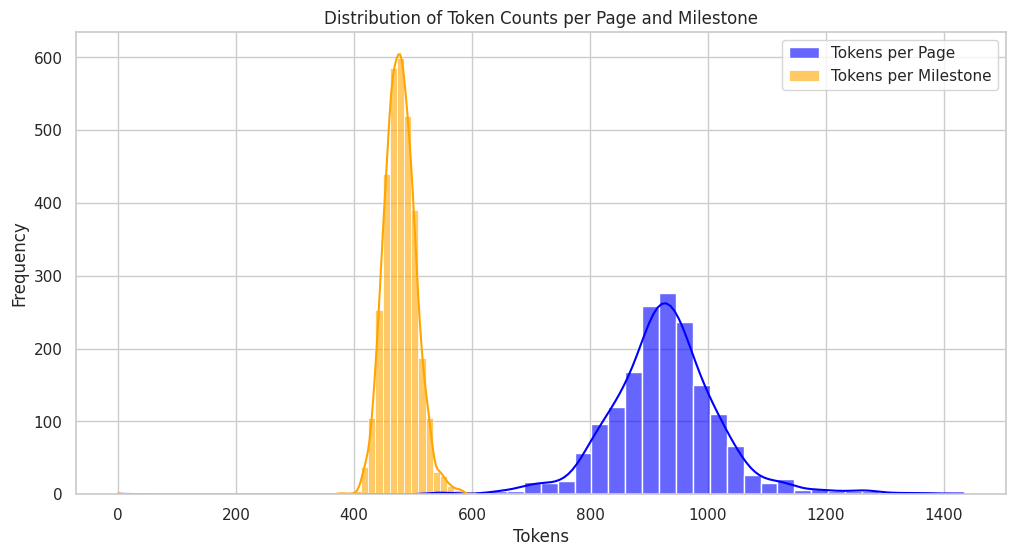

In [27]:
plt.figure(figsize=(12, 6))

sns.histplot(token_counts_pages, bins=50, kde=True, color='blue', label='Tokens per Page', alpha=0.6)

sns.histplot(token_counts_milestones, bins=50, kde=True, color='orange', label='Tokens per Milestone', alpha=0.6)

plt.title('Distribution of Token Counts per Page and Milestone')
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.show()


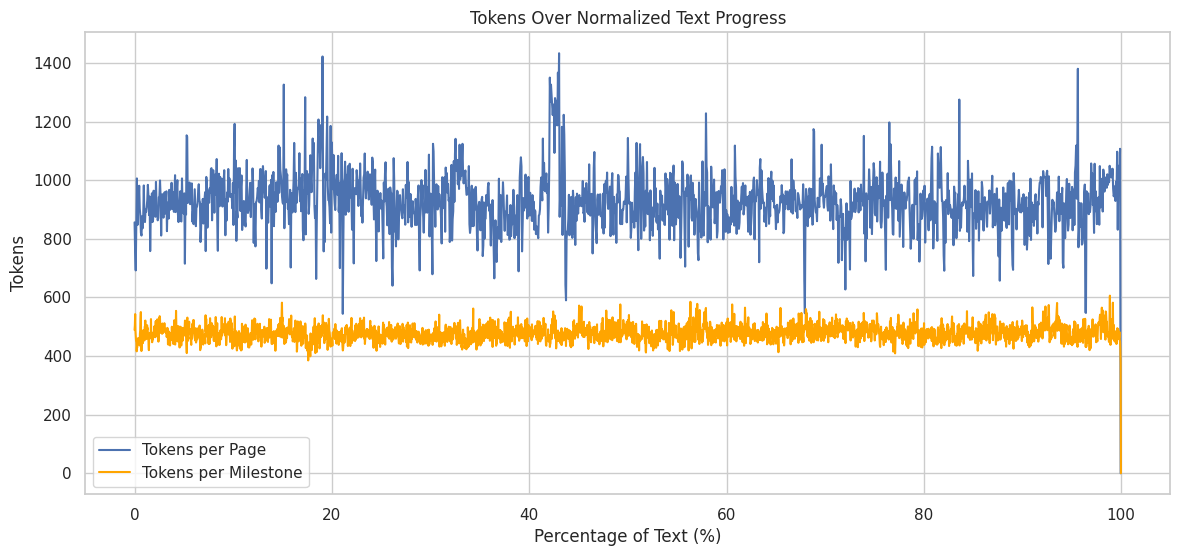

In [28]:
plt.figure(figsize=(14, 6))

x_pages = df_tokens_per_page.index / len(df_tokens_per_page) * 100
x_milestones = df_tokens_per_milestone.index / len(df_tokens_per_milestone) * 100

sns.lineplot(x=x_pages, y='tokens', data=df_tokens_per_page, label='Tokens per Page')

sns.lineplot(x=x_milestones, y='tokens', data=df_tokens_per_milestone, color='orange', label='Tokens per Milestone')

plt.title('Tokens Over Normalized Text Progress')
plt.xlabel('Percentage of Text (%)')
plt.ylabel('Tokens')
plt.legend()
plt.show()

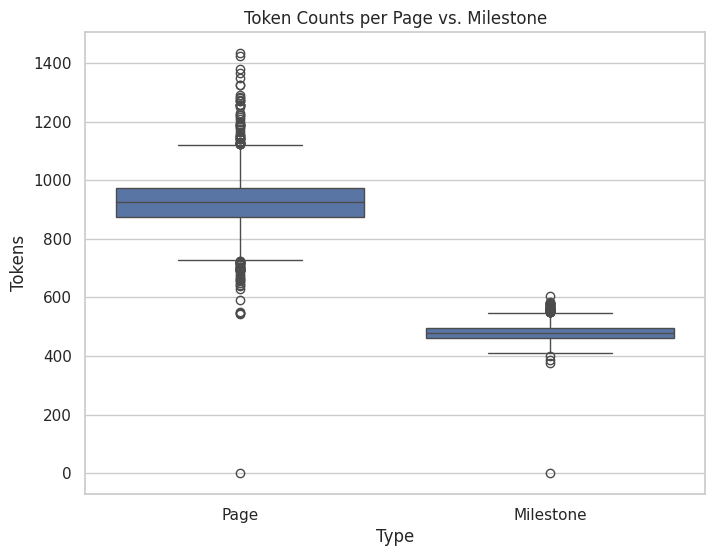

In [29]:
df_box = pd.DataFrame({
    'Tokens': token_counts_pages.tolist() + token_counts_milestones.tolist(),
    'Type': ['Page'] * len(token_counts_pages) + ['Milestone'] * len(token_counts_milestones)
})

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Tokens', data=df_box)
plt.title('Token Counts per Page vs. Milestone')
plt.show()

In [30]:
token_limit = 500

exceeding_pages = df_tokens_per_page[df_tokens_per_page['tokens'] > token_limit]
percentage_exceeding_pages = len(exceeding_pages) / len(df_tokens_per_page) * 100

print(f"Pages exceeding {token_limit} tokens: {len(exceeding_pages)} out of {len(df_tokens_per_page)} ({percentage_exceeding_pages:.2f}%)")

exceeding_milestones = df_tokens_per_milestone[df_tokens_per_milestone['tokens'] > token_limit]
percentage_exceeding_milestones = len(exceeding_milestones) / len(df_tokens_per_milestone) * 100

print(f"Milestones exceeding {token_limit} tokens: {len(exceeding_milestones)} out of {len(df_tokens_per_milestone)} ({percentage_exceeding_milestones:.2f}%)")

Pages exceeding 500 tokens: 1705 out of 1706 (99.94%)
Milestones exceeding 500 tokens: 614 out of 3307 (18.57%)


In [31]:
book_text = content

print(f"Author: {author}, Book: {book}")

Author: محمد بن محمد الغزالي أبو حامد, Book: إحياء علوم الدين


## Chunking

- We prepare the text by stripping all non Arabic characters.
- We save the page markers positions to be able to assign page and volume values for each text.
- We use LangChain's text splitter.
  - chunk size is 500 token.
  - There is an overlap of 100 token.
  - This is to prevent semantic cutoff between chunks.
  - The length function is the tokenizer function.
- For each chunk we save the start and end positions in the text.
- We use this to map the chunk positions in the text, to the positions of page markers.
- Chunks can be contained within a single page, or span 2 pages.
- In reality, the textsplitter dynamically sets chunk spread to prevent page span, but we check for it.

In [32]:
page_marker_pattern = r'PageV\d+P\d+'

page_marker_regex = re.compile(page_marker_pattern)

def cleaning_regex(match):
    text = match.group(0)
    if page_marker_regex.fullmatch(text):
        return text
    else:
        return ''

cleaned_text = re.sub(
    r'PageV\d+P\d+|[^\u0600-\u06FF\s]',
    cleaning_regex,
    book_text
)

cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

print("Cleaned text prepared for chunking.")
print(f"Total length of cleaned text: {len(cleaned_text)} characters")

Cleaned text prepared for chunking.
Total length of cleaned text: 5133147 characters


In [33]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100,
    length_function=get_token_count
)

chunks = text_splitter.split_text(cleaned_text)

print(f"Total chunks created: {len(chunks)}")


Total chunks created: 3978


In [47]:
page_markers_in_cleaned_text = list(re.finditer(page_marker_pattern, cleaned_text))

page_positions_data = []
for marker in page_markers_in_cleaned_text:
    page_marker = marker.group()
    volume_match = re.search(r'PageV(\d+)P(\d+)', page_marker)
    volume_num = volume_match.group(1)
    page_num = volume_match.group(2)
    position = marker.start()
    page_positions_data.append({
        'volume': f'V{volume_num}',
        'page': f'P{page_num}',
        'position': position
    })

page_positions_df = pd.DataFrame(page_positions_data)

print("\nFirst few page markers with positions in cleaned text:")
print(page_positions_df.head())


First few page markers with positions in cleaned text:
  volume  page  position
0    V01  P001      2203
1    V01  P002      4955
2    V01  P003      7404
3    V01  P004      9867
4    V01  P005     12849


In [54]:
chunk_data = []

for idx, chunk_text in enumerate(chunks):
    start_index = cleaned_text.find(chunk_text)

    end_index = start_index + len(chunk_text) - 1

    token_count = get_token_count(chunk_text)

    chunk_data.append({
        'chunk_num': idx + 1,
        'chunk_text': chunk_text,
        'start_index': start_index,
        'end_index': end_index,
        'token_count': token_count
    })

df_chunks = pd.DataFrame(chunk_data)

In [55]:
df_chunks

,chunk_num,chunk_text,start_index,end_index,token_count
0,1,بسم الله الرحمن الرحيم أحمد الله أولا حمدا كثي...,0,1535,500
1,2,في الأسفار فاقتصرت فيه على ذكر طرف الحديث وصحا...,1214,2792,500
2,3,العلم طمعا في نيل ما تعبده الله تعالى به من تز...,2490,4034,498
3,4,وشبكة للحطام فأما علم طريق الآخرة وما درج عليه...,3745,5359,499
4,5,الكسب وكتاب الحلال والحرام وكتاب آداب الصحبة و...,5050,6653,499
...,...,...,...,...,...
3973,3974,منها كما تخرج الحبة فى حميل السيل ألا ترونها ت...,5127397,5129086,500
3974,3975,صلى الله عليه وسلم فقال هم الذين لا يكتوون ولا...,5128730,5130355,499
3975,3976,فأعطانى هكذا وفرج عبد الله بن أبى بكر بين يديه...,5130037,5131693,500
3976,3977,مكانه النار يهوديا أو نصرانيا فاستحلفه عمر بن ...,5131347,5133042,498


In [56]:
pages_list = []
volumes_list = []

for idx, chunk in df_chunks.iterrows():
    start_idx = chunk['start_index']
    end_idx = chunk['end_index']

    overlapping_pages_df = page_positions_df[
        (page_positions_df['position'] >= start_idx) & (page_positions_df['position'] <= end_idx)
    ]

    if overlapping_pages_df.empty:
        if start_idx < page_positions_df['position'].iloc[0]:
            pages = [page_positions_df['page'].iloc[0]]
            volumes = [page_positions_df['volume'].iloc[0]]
        else:
            preceding_pages_df = page_positions_df[page_positions_df['position'] <= start_idx]
            if not preceding_pages_df.empty:
                last_preceding_page = preceding_pages_df.iloc[-1]
                pages = [last_preceding_page['page']]
                volumes = [last_preceding_page['volume']]
            else:
                pages = ['Unknown']
                volumes = ['Unknown']
    else:
        pages = overlapping_pages_df['page'].tolist()
        volumes = overlapping_pages_df['volume'].tolist()

    pages_list.append(pages)
    volumes_list.append(volumes)

df_chunks['page'] = pages_list
df_chunks['volume'] = volumes_list

In [66]:

df_chunks['chunk_text'] = df_chunks['chunk_text'].str.replace(page_marker_pattern, '', regex=True)
df_chunks['chunk_text'] = df_chunks['chunk_text'].str.replace(r'\s+', ' ', regex=True).str.strip()

df_chunks['author'] = author
df_chunks['book'] = book

df_chunks['page'] = df_chunks['page'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)
df_chunks['volume'] = df_chunks['volume'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)

df_chunks.rename(columns={'chunk_text': 'text'}, inplace=True)
df_chunks.drop(columns=['chunk_num'], inplace=True)

## Results

- We have created a dataset of text chunks of 500 tokens.
- The chunks overlap by 100 tokens to preserve semantic continuity.
- Each chunk preserves it's position in the text via page + volume notation.

In [67]:
df_chunks

,text,start_index,end_index,token_count,page,volume,author,book
0,بسم الله الرحمن الرحيم أحمد الله أولا حمدا كثي...,0,1535,500,P001,V01,محمد بن محمد الغزالي أبو حامد,إحياء علوم الدين
1,في الأسفار فاقتصرت فيه على ذكر طرف الحديث وصحا...,1214,2792,500,P001,V01,محمد بن محمد الغزالي أبو حامد,إحياء علوم الدين
2,العلم طمعا في نيل ما تعبده الله تعالى به من تز...,2490,4034,498,P001,V01,محمد بن محمد الغزالي أبو حامد,إحياء علوم الدين
3,وشبكة للحطام فأما علم طريق الآخرة وما درج عليه...,3745,5359,499,P002,V01,محمد بن محمد الغزالي أبو حامد,إحياء علوم الدين
4,الكسب وكتاب الحلال والحرام وكتاب آداب الصحبة و...,5050,6653,499,P002,V01,محمد بن محمد الغزالي أبو حامد,إحياء علوم الدين
...,...,...,...,...,...,...,...,...
3973,منها كما تخرج الحبة فى حميل السيل ألا ترونها ت...,5127397,5129086,500,P545,V04,محمد بن محمد الغزالي أبو حامد,إحياء علوم الدين
3974,صلى الله عليه وسلم فقال هم الذين لا يكتوون ولا...,5128730,5130355,499,P546,V04,محمد بن محمد الغزالي أبو حامد,إحياء علوم الدين
3975,فأعطانى هكذا وفرج عبد الله بن أبى بكر بين يديه...,5130037,5131693,500,P546,V04,محمد بن محمد الغزالي أبو حامد,إحياء علوم الدين
3976,مكانه النار يهوديا أو نصرانيا فاستحلفه عمر بن ...,5131347,5133042,498,P546,V04,محمد بن محمد الغزالي أبو حامد,إحياء علوم الدين


In [68]:
df_chunks.to_parquet('df_chunks.parquet', index=False)